# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [1]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal
import utils

In [2]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib ipympl
import matplotlib.pyplot as plt

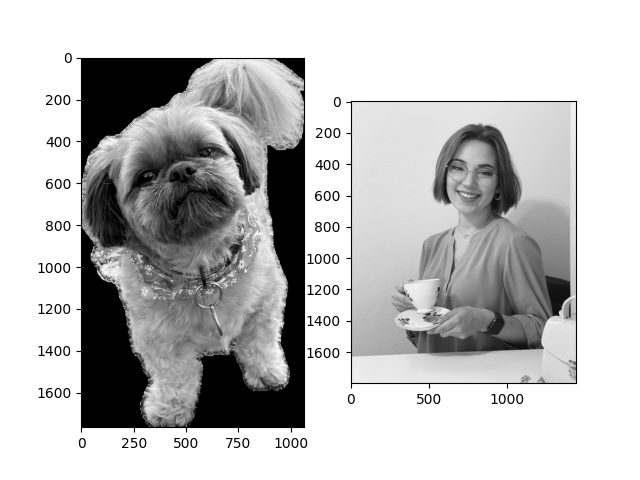

In [3]:
datadir = "./"

# im1_file = datadir + 'nutmeg.jpg'
# im2_file = datadir + 'DerekPicture.jpg'

# im1_file = datadir + 'paddy_zoom.JPG'
im1_file = datadir + 'max.png'
im2_file = datadir + 'MK_teacup.JPG'

im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')
plt.show()

#### Get Eye Points

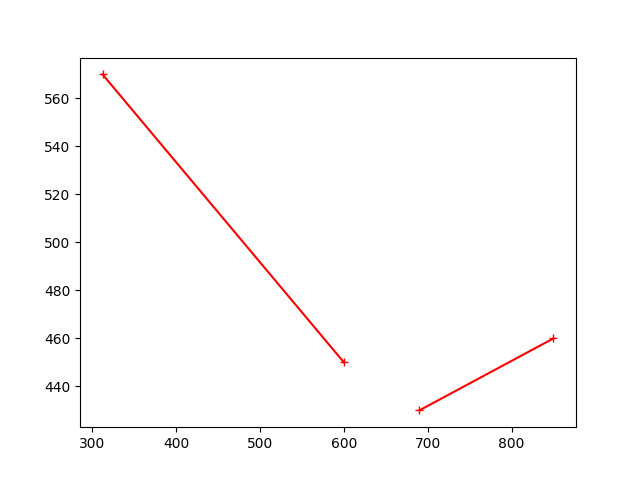

In [4]:
plt.figure()

# pts_im1 = utils.prompt_eye_selection(im1)
# pts_im1 = np.array([[655, 425], [680, 1180]]) # uncomment if entering [x, y] pts manually
# pts_im1 = np.array([[425, 655], [1180, 680]]) # uncomment if entering [x, y] pts manually # paddy
# pts_im1 = np.array([[155, 186], [325, 148]]) # uncomment if entering [x, y] pts manually # loki upnose
pts_im1 = np.array([[312, 570], [600, 450]]) # uncomment if entering [x, y] pts manually # max
plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')

# pts_im2 = utils.prompt_eye_selection(im2)
# pts_im2 = np.array([[430,690], [460,850]]) # uncomment if entering [x, y] pts manually
pts_im2 = np.array([[690, 430], [850, 460]]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')

In [5]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)

In [6]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

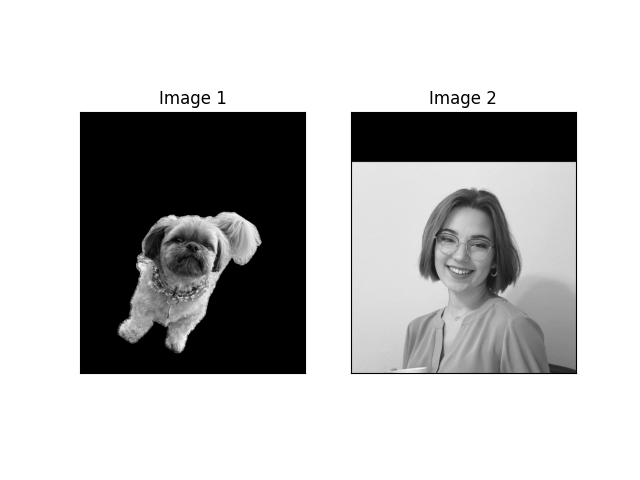

In [7]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

In [8]:
def makePaddedGaussFilter(shape, sigma):
    ##### Create Gaussian kernel just like if this was spatial domain
    kernel_size = int(np.ceil(sigma) * 6 + 1)
    if kernel_size % 2 == 0:  # Ensure odd kernel size, or else weird shape stuff happens
        kernel_size += 1
        
    gauss_kernel = cv2.getGaussianKernel(kernel_size, sigma)  # 1D kernel
    gauss_kernel = gauss_kernel @ gauss_kernel.T  # 2D kernel by outer product

    # Create zero matrix to act as padding
    rows, cols = shape
    gaussian_filter = np.zeros((rows, cols), dtype=np.float32)

    # Add the kernel to the center of the zero matrix
    start_row = (rows - kernel_size) // 2
    start_col = (cols - kernel_size) // 2
    gaussian_filter[start_row:start_row + kernel_size, start_col:start_col + kernel_size] = gauss_kernel

    # Upscale the filter to be from 0 to 1 (for mult with fft img)
    return gaussian_filter / np.max(gaussian_filter)

In [ ]:
def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    
    fig, ax = plt.subplots(3, 3, figsize=(10, 12))
    rows, cols = im1.shape

    ##### Take FFT of images using numpy
    im1_fft = np.fft.fft2(im1)
    im1_fft_shifted = np.fft.fftshift(im1_fft)

    im2_fft = np.fft.fft2(im2)
    im2_fft_shifted = np.fft.fftshift(im2_fft)

    ##### Plot the spectrums of the images
    magnitude_spectrum1 = 20 * np.log(np.abs(im1_fft_shifted) + 1)
    ax[0][0].imshow(magnitude_spectrum1, cmap='jet')
    ax[0][0].set_title('FFT of im1')

    magnitude_spectrum2 = 20 * np.log(np.abs(im2_fft_shifted) + 1)
    ax[1][0].imshow(magnitude_spectrum2, cmap='jet')
    ax[1][0].set_title('FFT of im2')

    ##### High Pass Filter
    hpf_gauss = makePaddedGaussFilter(im1.shape, sigma_high)
    ones_matrix = np.ones((rows, cols), dtype=np.float32)
    high_pass_filter = ones_matrix - hpf_gauss

    ax[0][1].imshow(high_pass_filter, cmap='gray')
    ax[0][1].set_title('HPF Inverse Gauss')

    ##### Low Pass Filter
    low_pass_filter = makePaddedGaussFilter(im2.shape, sigma_low)

    ax[1][1].imshow(low_pass_filter, cmap='gray')
    ax[1][1].set_title('LPF Gauss')

    ##### Apply the filters directly in the frequency domain
    high_filtered_fft = im1_fft_shifted * high_pass_filter
    low_filtered_fft = im2_fft_shifted * low_pass_filter

    ##### Convert back to spatial domain
    # Take only real part (I think this is fine?)
    low_img_back = np.real(np.fft.ifft2(np.fft.ifftshift(low_filtered_fft)))
    high_img_back = np.real(np.fft.ifft2(np.fft.ifftshift(high_filtered_fft)))

    # Filtered visualizations
    print(f"high image range: [{high_img_back.min():.4f}, {high_img_back.max():.4f}]")
    ax[0][2].imshow(high_img_back, cmap='gray', vmin=0, vmax=1)
    ax[0][2].set_title('high-pass')

    print(f"low image range: [{low_img_back.min():.4f}, {low_img_back.max():.4f}]")
    ax[1][2].imshow(low_img_back, cmap='gray', vmin=0, vmax=1)
    ax[1][2].set_title('low-pass')

    ##### Combine images
    hybrid_image = (low_img_back + high_img_back) / 2.0
    ax[2][1].imshow(hybrid_image, cmap='gray', vmin=0, vmax=1
                    )
    ax[2][1].set_title("hybrid image result")

    fig.delaxes(ax[2][0])
    fig.delaxes(ax[2][2])
    plt.tight_layout()
    plt.show()
    
    return hybrid_image



high image range: [-0.5814, 0.7380]
low image range: [-0.0001, 0.9006]


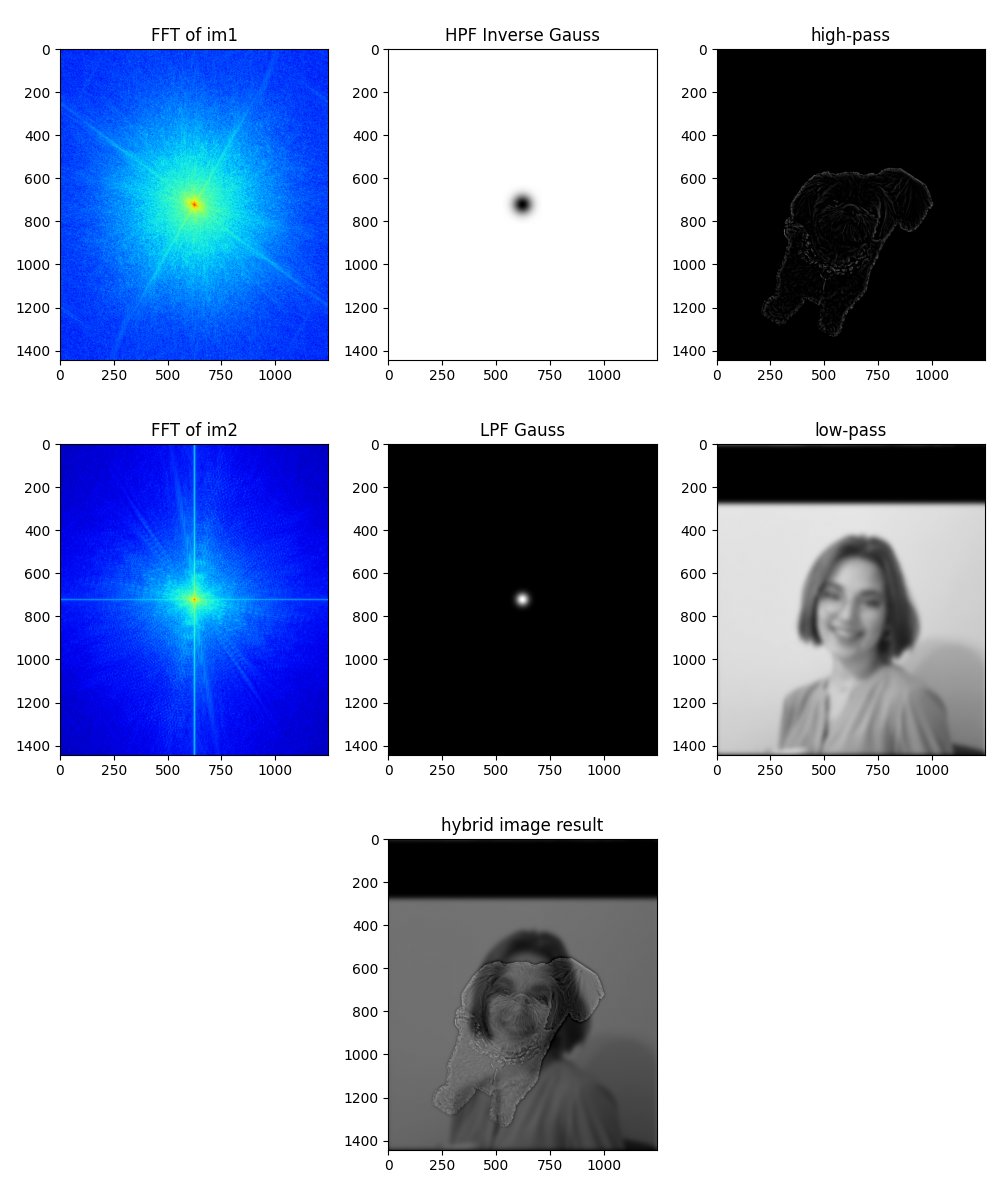

In [10]:
sigma_low = 20 # choose parameters that work for your images
sigma_high = 30

im_hybrid = hybridImage(im1, im2, sigma_low, sigma_high)


### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

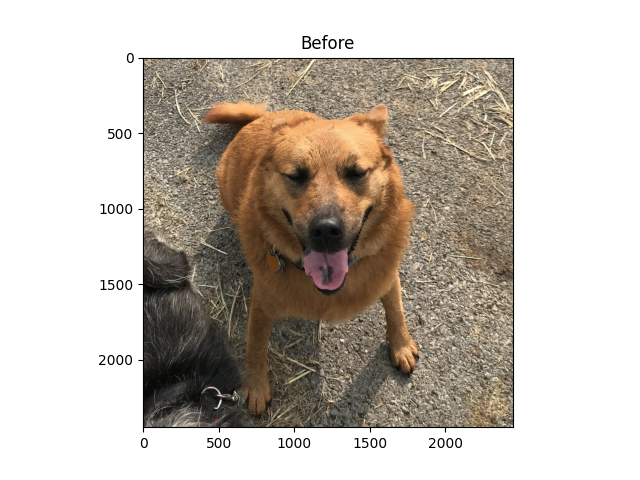

In [14]:
plt.figure()
im3_file = datadir + "paddy.jpg"
im3 = cv2.imread(im3_file, cv2.IMREAD_COLOR_RGB)

plt.imshow(im3)
plt.title("Before")
plt.show()

#### Color enhancement 

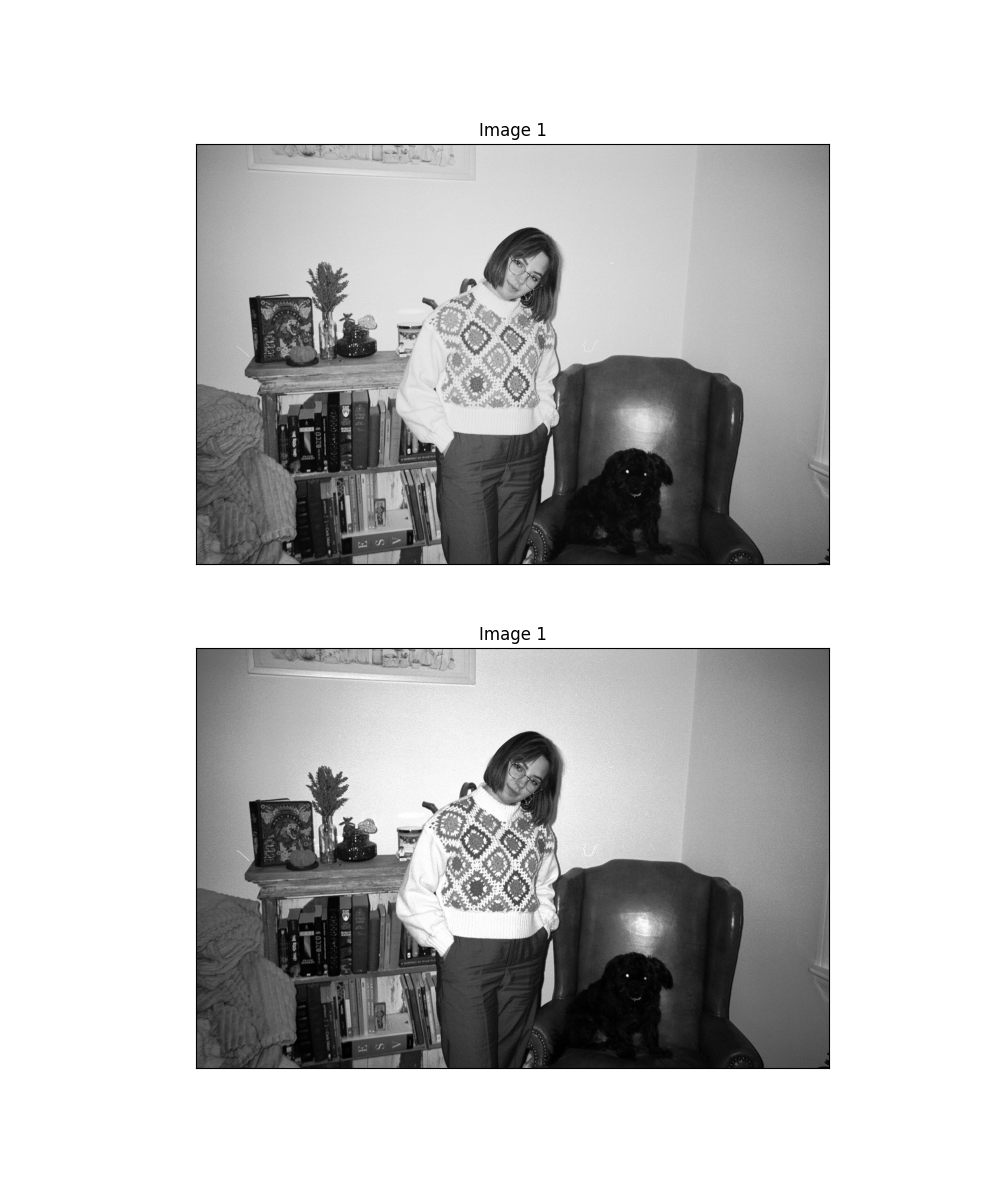

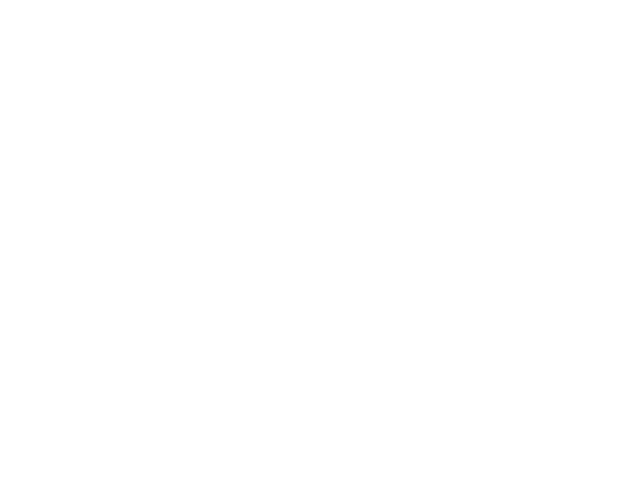

In [ ]:
plt.figure()
im4_file = datadir + "mk-and-loki.jpg"
# im4 = cv2.imread(im4_file, cv2.IMREAD_COLOR_RGB)
im4 = cv2.imread(im4_file, cv2.IMREAD_GRAYSCALE)

hist,bins = np.histogram(im4.flatten(),256,[0,256])
 
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
 
equ = cv2.equalizeHist(im4)
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].imshow(im4, cmap='gray')
ax[0].set_title('Before'), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(equ, cmap='gray')
ax[1].set_title('After'), ax[1].set_xticks([]), ax[1].set_yticks([])

plt.show()


# plt.plot(cdf_normalized, color = 'b')
# plt.hist(im4.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()

# plt.imshow(im4, cmap='gray')
# plt.title("Before")
# plt.show()

#### Color shift

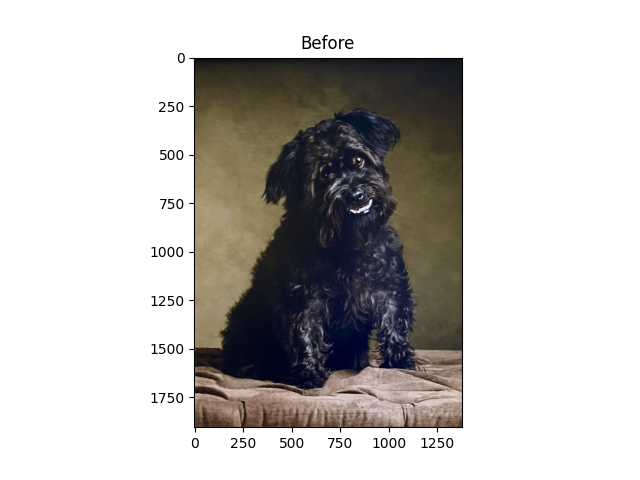

In [13]:
plt.figure()
im5_file = datadir + "Loki_portrait.jpg"
im5 = cv2.imread(im5_file, cv2.IMREAD_COLOR_RGB)

plt.imshow(im5)
plt.title("Before")
plt.show()
